Anna Karenina characters: 1,981,509
War and Peace characters: 3,221,495
Anna Karenina paragraphs: 6,308
War and Peace paragraphs: 9,747


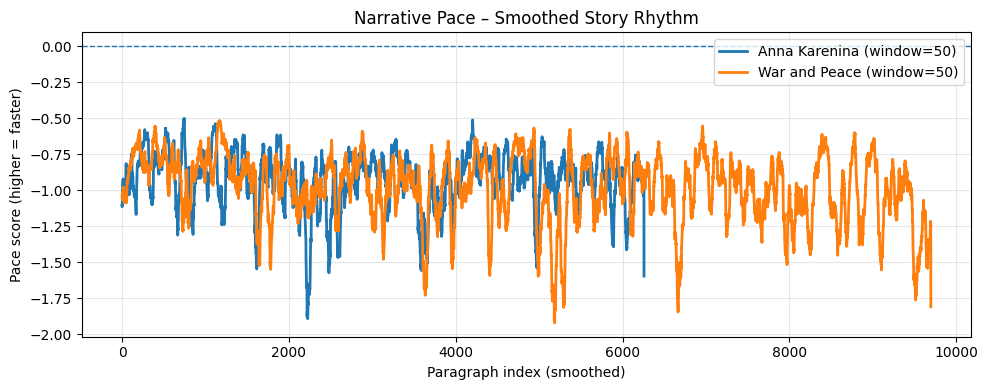

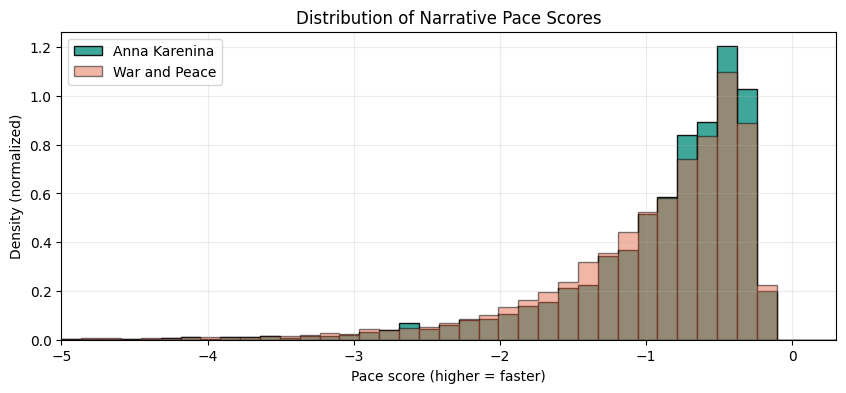

In [1]:
# Session 4 — Paragraph-Level Analysis
# New Topic: Narrative Pace & Rhythm Modeling
# Books: Anna Karenina & War and Peace

import re
from typing import List
import numpy as np
import matplotlib.pyplot as plt


# ---------------------------------------------------------
# 1. Load and lightly clean a Project Gutenberg book
# ---------------------------------------------------------
def load_book(filepath: str) -> str:
    """Load and lightly clean a book text (Project Gutenberg style)."""
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()

    if '*** START OF' in text:
        start = text.find('*** START OF')
        text = text[start + 200:]
    return text.strip()


# ---------------------------------------------------------
# 2. Split into paragraphs and sentences
# ---------------------------------------------------------
def split_into_paragraphs(text: str, min_words: int = 10) -> List[str]:
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    raw_paras = re.split(r'\n\s*\n+', text)
    paras = []
    for p in raw_paras:
        cleaned = re.sub(r'\s+', ' ', p).strip()
        if len(cleaned.split()) >= min_words:
            paras.append(cleaned)
    return paras


def sentence_split(paragraph: str) -> List[str]:
    sentences = re.split(r'[.!?]+\s+', paragraph.strip())
    return [s.strip() for s in sentences if s.strip()]


# ---------------------------------------------------------
# 3. Pacing features + pacing score
# ---------------------------------------------------------
def pacing_features(paragraphs: List[str]):
    pacing = []
    for p in paragraphs:
        words = p.split()
        if len(words) == 0:
            continue

        sents = sentence_split(p)
        if not sents:
            continue

        avg_sent_len = np.mean([len(s.split()) for s in sents])
        dialogue_density = p.count('"') / len(words)

        pacing.append({
            "length": len(words),
            "avg_sentence_length": avg_sent_len,
            "dialogue_density": dialogue_density
        })
    return pacing


def pacing_score(entry):
    return (
        2.0 * entry["dialogue_density"]
        - 0.01 * entry["length"]
        - 0.02 * entry["avg_sentence_length"]
    )


# ---------------------------------------------------------
# 4. Load YOUR FILES
# ---------------------------------------------------------
anna_karenina_text = load_book('../data/The Project Gutenberg eBook of Anna Karenina, by Leo Tolstoy.txt')
war_and_peace_text = load_book('../data/The Project Gutenberg eBook of War and Peace, by Leo Tolstoy.txt')



print(f"Anna Karenina characters: {len(anna_karenina_text):,}")
print(f"War and Peace characters: {len(war_and_peace_text):,}")

anna_paras = split_into_paragraphs(anna_karenina_text)
war_paras = split_into_paragraphs(war_and_peace_text)

print(f"Anna Karenina paragraphs: {len(anna_paras):,}")
print(f"War and Peace paragraphs: {len(war_paras):,}")


# ---------------------------------------------------------
# 5. Compute pacing features
# ---------------------------------------------------------
anna_scores = [pacing_score(e) for e in pacing_features(anna_paras)]
war_scores  = [pacing_score(e) for e in pacing_features(war_paras)]


# ---------------------------------------------------------
# 6. Visualization – cleaner & more informative
# ---------------------------------------------------------

def clip_scores(scores, min_val=-10, max_val=2):
    """Clip extreme outliers so the plot scale stays readable."""
    scores = np.array(scores, dtype=float)
    return np.clip(scores, min_val, max_val)

def moving_average(values, window=50):
    """Smooth the curve to show overall rhythm instead of noisy wiggles."""
    values = np.array(values, dtype=float)
    if len(values) < window:
        return values
    kernel = np.ones(window) / window
    return np.convolve(values, kernel, mode="valid")


# 6A. Smoothed “story rhythm” for both books together
window = 50  # paragraphs per smoothing window

anna_smooth = moving_average(anna_scores, window=window)
war_smooth  = moving_average(war_scores,  window=window)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(anna_smooth, label=f"Anna Karenina (window={window})", linewidth=2)
ax.plot(war_smooth,  label=f"War and Peace (window={window})", linewidth=2)
ax.axhline(0, linestyle="--", linewidth=1)

ax.set_title("Narrative Pace – Smoothed Story Rhythm")
ax.set_xlabel("Paragraph index (smoothed)")
ax.set_ylabel("Pace score (higher = faster)")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# 6B. Compare overall pace distributions with histograms
import numpy as np

fig, ax = plt.subplots(figsize=(10, 4))

bins = np.linspace(-5, 0.3, 40)

ax.hist(anna_scores, bins=bins, density=True, alpha=0.9, label="Anna Karenina",
        color="#2A9D8F", edgecolor='black')

ax.hist(war_scores, bins=bins, density=True, alpha=0.5, label="War and Peace",
        color="#E76F51", edgecolor='black', histtype='stepfilled')

ax.set_xlim(-5, 0.3)
ax.set_title("Distribution of Narrative Pace Scores")
ax.set_xlabel("Pace score (higher = faster)")
ax.set_ylabel("Density (normalized)")
ax.legend()
ax.grid(True, alpha=0.25)
plt.show()



